In [2]:
%matplotlib notebook
%matplotlib inline

# Dependencies 
import pandas as pd
import matplotlib.pyplot as plt
import requests
import json
import time
import gmaps

# Google developer API key 
from config import gkey
gmaps.configure(api_key=gkey)



In [3]:
#Study Years -- For project using 2012 to 2018
startYear = '2012'
endYear ='2018'


In [4]:
#Create a basic data frame using the NC Counties CSV File
counties_csv = 'data_import/NC_Counties.csv'
proj_df = pd.read_csv(counties_csv, usecols=[3,4])
#preview
#proj_df.shape
proj_df.head()

,CO_NAME,CO_ABBR
0,ROCKINGHAM,ROCK
1,GUILFORD,GUIL
2,ALAMANCE,ALAM
3,ALEXANDER,ALEX
4,RANDOLPH,RAND


In [5]:
# Add fields to dataframe to hold data that will be collected via API
proj_df['Latitude']=''
proj_df['Longitude']=''
proj_df['Start_Yr_Pop']=''
proj_df['End_Yr_Pop']=''

#preview to confirm
proj_df.head()

,CO_NAME,CO_ABBR,Latitude,Longitude,Start_Yr_Pop,End_Yr_Pop
0,ROCKINGHAM,ROCK,,,,
1,GUILFORD,GUIL,,,,
2,ALAMANCE,ALAM,,,,
3,ALEXANDER,ALEX,,,,
4,RANDOLPH,RAND,,,,


In [6]:
#populate the added fields via API
url = "https://demography.osbm.nc.gov/api/records/1.0/search/?"
dataset = 'county-population-estimates-standard-revised'
cc ='' #this is just used to print out data as the API is executing

#populate the starting year pop and grab coordinates
for index, row in proj_df.iterrows():
    
    #build query url
    county = row['CO_NAME'].title() #the NCBM requires county paramater to be in titlecase
    date ='July+1%2C+'
    year = startYear
    qurl = f'{url}dataset={dataset}&facet=county&facet=year&refine.county={county}+County&refine.year={date}{year}'
    
    #build a response Object
    response = requests.get(qurl)
    #build a JSON object from response
    response_json = response.json()
    #print(response_json["nhits"])
    
    #populate cells
    try:
        proj_df.loc[index, ['Latitude']] = response_json["records"][0]['fields']["geo_point_2d"][0]
        proj_df.loc[index, ['Longitude']] = response_json["records"][0]['fields']["geo_point_2d"][1]
        proj_df.loc[index, ['Start_Yr_Pop']] = response_json["records"][0]['fields']['population']
        cc = response_json["records"][0]['fields']['county']
        print(f'Retrieved {startYear} for {cc}')
        
    except IndexError:
        proj_df.loc[index, ['Start_Yr_Pop']] = None
     
    #sleep based on last response, lets us know if server slowing down
    time.sleep(response.elapsed.total_seconds())
              
#populate the ending year pop
for index, row in proj_df.iterrows():
    
    #build query url
    county = row['CO_NAME'].title() #the NCBM requires county paramater to be in titlecase
    date ='July+1%2C+'
    year = endYear
    qurl = f'{url}dataset={dataset}&facet=county&facet=year&refine.county={county}+County&refine.year={date}{year}'
    
    #build a response Object
    response = requests.get(qurl)
    #build a JSON object from response
    response_json = response.json()
    #print(response_json["nhits"])
    
    #populate cells
    try:
        proj_df.loc[index, ['End_Yr_Pop']] = response_json["records"][0]['fields']['population']
        cc = response_json["records"][0]['fields']['county']
        print(f'Retrieved {endYear} for {cc}')
        
    except IndexError:
        proj_df.loc[index, ['End_Yr_Pop']] = None
     
    #sleep based on last response, lets us know if server slowing down
    time.sleep(response.elapsed.total_seconds())
        
    

        
print('The data frame has been updated via API')



Retrieved 2012 for Rockingham County
Retrieved 2012 for Guilford County
Retrieved 2012 for Alamance County
Retrieved 2012 for Alexander County
Retrieved 2012 for Randolph County
Retrieved 2012 for Wayne County
Retrieved 2012 for Ashe County
Retrieved 2012 for Alleghany County
Retrieved 2012 for Currituck County
Retrieved 2012 for Camden County
Retrieved 2012 for Surry County
Retrieved 2012 for Gates County
Retrieved 2012 for Hertford County
Retrieved 2012 for Northampton County
Retrieved 2012 for Stokes County
Retrieved 2012 for Warren County
Retrieved 2012 for Vance County
Retrieved 2012 for Granville County
Retrieved 2012 for Caswell County
Retrieved 2012 for Person County
Retrieved 2012 for Pasquotank County
Retrieved 2012 for Halifax County
Retrieved 2012 for Wilkes County
Retrieved 2012 for Watauga County
Retrieved 2012 for Perquimans County
Retrieved 2012 for Chowan County
Retrieved 2012 for Avery County
Retrieved 2012 for Yadkin County
Retrieved 2012 for Dare County
Retrieved 20

In [20]:
#drop na rows
proj_df = proj_df.dropna().copy()

 #add column for % change
proj_df['Perc_Change']= ((proj_df['End_Yr_Pop'] - proj_df['Start_Yr_Pop'])/proj_df['Start_Yr_Pop'])*100
proj_df['Abs_Change']= (proj_df['End_Yr_Pop'] - proj_df['Start_Yr_Pop'])

 #add a boolean column for % change > 10%
proj_df['High_Growth']= proj_df['Perc_Change'] >= 10
    
 #sort in descending order
proj_df.sort_values(by = ['Perc_Change'] , ascending=False, inplace = True)
proj_df = proj_df.reset_index(drop = True)

#check that data frame was populated
proj_df.head()





,CO_NAME,CO_ABBR,Latitude,Longitude,Start_Yr_Pop,End_Yr_Pop,Perc_Change,Abs_Change,High_Growth
0,BRUNSWICK,BRUN,34.039,-78.2273,112409,137103,21.968,24694,True
1,PENDER,PEND,34.5151,-77.8884,54070,62168,14.9769,8098,True
2,JOHNSTON,JOHN,35.5178,-78.3657,174207,199790,14.6854,25583,True
3,CABARRUS,CABA,35.3868,-80.5518,183253,209150,14.1318,25897,True
4,CHATHAM,CHAT,35.7026,-79.2553,65152,74264,13.9858,9112,True


<IPython.core.display.Javascript object>


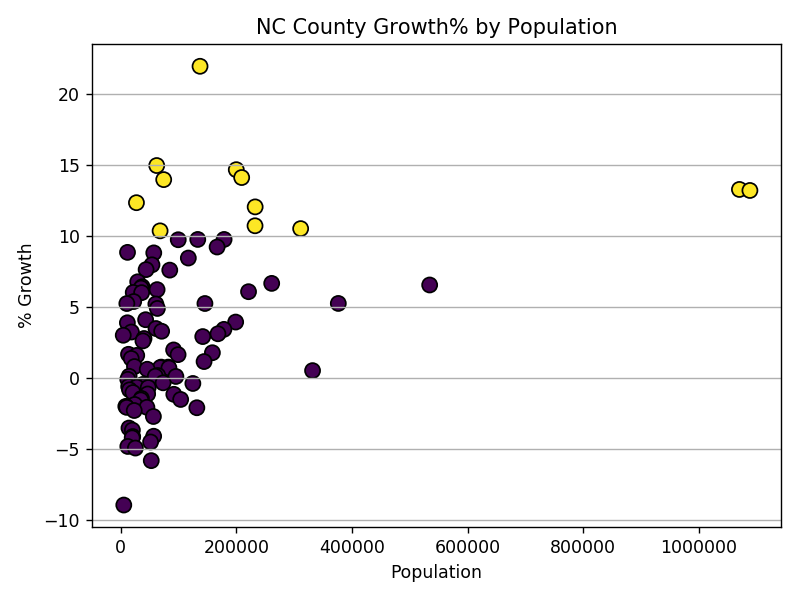

In [48]:
#plot population by population growth data points to see how they cluster

plt.scatter(proj_df.End_Yr_Pop, proj_df.Perc_Change,  edgecolors='black', c = proj_df.High_Growth, s = 75)
plt.grid(which ='major', axis = 'y')
plt.title('NC County Growth% by Population')
plt.xlabel('Population')
plt.ylabel('% Growth')
plt.tight_layout()
plt.savefig('img/NC_Cnty_GrowthByPop_Scat.png')
plt.show()



In [ ]:
#Build df that has counties with + growth and perc change > than national pop increase% over same time
cnty_growth = proj_df[proj_df['Perc_Change'] >= 10]

# Export file as a CSV, without the Pandas index, but with the header
cnty_growth.to_csv('data_export/cnty_growth.csv', index=False, header=True)

cnty_growth.head(15)

In [9]:
#Build gmaps for top growth counties

# Store 'Lat' and 'Lng' into  locations 
locations = cnty_growth[['Latitude', 'Longitude']].astype(float)

# Convert County Growth (%Change) to float and store
growth = cnty_growth['Perc_Change'].astype(float)



In [10]:
# Add symbol layer for top growth counties for abs growth
abs_grow = cnty_growth['Abs_Change'].tolist()

sym_layer = gmaps.symbol_layer(
    locations, fill_color='rgba(0, 150, 0, 0.4)',
    stroke_color='rgba(0, 0, 150, 0.4)', scale=2,
    #info_box_content=[f"Abs Growth: {bank}" for cnty in abs_grow]
)


fig = gmaps.figure()
fig.add_layer(sym_layer)

fig

Figure(layout=FigureLayout(height='420px'))

In [11]:
# Add heatmap layer for growth rate
fig = gmaps.figure()

heat_layer = gmaps.heatmap_layer(locations, weights=growth, 
                                 dissipating=False, max_intensity=100, point_radius = 1)
fig.add_layer(heat_layer)

fig

Figure(layout=FigureLayout(height='420px'))

In [12]:
# Create a combined map
fig = gmaps.figure()

fig.add_layer(heat_layer)
fig.add_layer(sym_layer)

fig

Figure(layout=FigureLayout(height='420px'))